# Importing the Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score,roc_auc_score,recall_score
import pickle

# Reading the dataset

In [3]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='9kWHD8b_g_fmN4r9ELkkp0sJskqoZfDYBZ8F3COMxMgW',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'universityadmiteligibilitypredict-donotdelete-pr-buurlnsfy85605'
object_key = 'Admission_Predict.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

data = pd.read_csv(body)
data.head()


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [4]:
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [5]:
data.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

In [6]:
data.shape

(400, 9)

# Data Pre-Processing

In [7]:
data.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [8]:
data.corr()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,1.000000,-0.097526,-0.147932,-0.169948,-0.166932,-0.088221,-0.045608,-0.063138,0.042336
GRE Score,-0.097526,1.000000,0.835977,0.668976,0.612831,0.557555,0.833060,0.580391,0.802610
TOEFL Score,-0.147932,0.835977,1.000000,0.695590,0.657981,0.567721,0.828417,0.489858,0.791594
University Rating,-0.169948,0.668976,0.695590,1.000000,0.734523,0.660123,0.746479,0.447783,0.711250
SOP,-0.166932,0.612831,0.657981,0.734523,1.000000,0.729593,0.718144,0.444029,0.675732
LOR,-0.088221,0.557555,0.567721,0.660123,0.729593,1.000000,0.670211,0.396859,0.669889
CGPA,-0.045608,0.833060,0.828417,0.746479,0.718144,0.670211,1.000000,0.521654,0.873289
Research,-0.063138,0.580391,0.489858,0.447783,0.444029,0.396859,0.521654,1.000000,0.553202
Chance of Admit,0.042336,0.802610,0.791594,0.711250,0.675732,0.669889,0.873289,0.553202,1.000000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         400 non-null    int64  
 1   GRE Score          400 non-null    int64  
 2   TOEFL Score        400 non-null    int64  
 3   University Rating  400 non-null    int64  
 4   SOP                400 non-null    float64
 5   LOR                400 non-null    float64
 6   CGPA               400 non-null    float64
 7   Research           400 non-null    int64  
 8   Chance of Admit    400 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 28.2 KB


In [10]:
data.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,200.500000,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,115.614301,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,100.750000,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,200.500000,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,300.250000,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,400.000000,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


In [11]:
print(set(data["University Rating"]),set(data["Research"]))

{1, 2, 3, 4, 5} {0, 1}


# Data Visualization

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='GRE Score', ylabel='CGPA'>

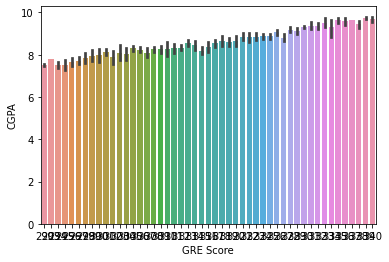

In [12]:
sns.barplot(data["GRE Score"],data["CGPA"])

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='TOEFL Score', ylabel='CGPA'>

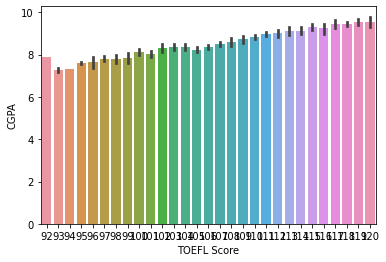

In [13]:
sns.barplot(data["TOEFL Score"],data["CGPA"])

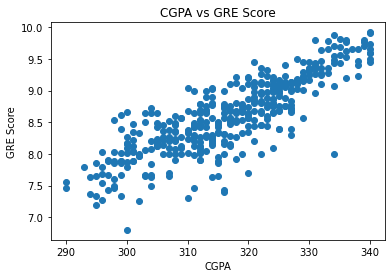

In [14]:
plt.scatter(data['GRE Score'],data['CGPA'])
plt.title('CGPA vs GRE Score')
plt.xlabel('CGPA')
plt.ylabel('GRE Score')
plt.show()

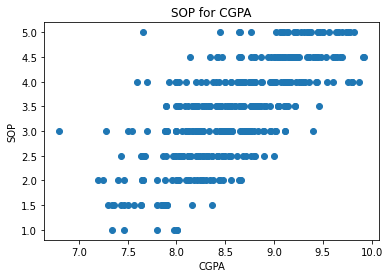

In [15]:
plt.scatter(data['CGPA'],data['SOP'])
plt.title('SOP for CGPA')
plt.xlabel('CGPA')
plt.ylabel('SOP')
plt.show()

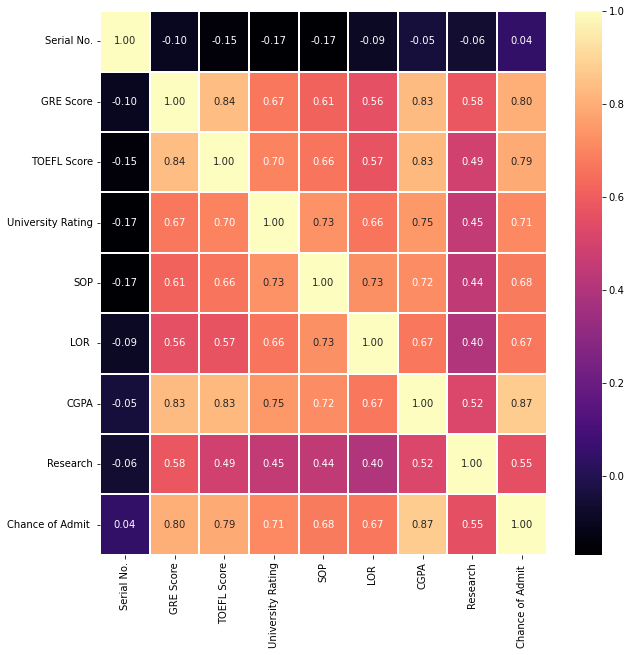

In [16]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True,linewidths=0.05,fmt='.2f',cmap="magma")
plt.show()

<AxesSubplot:xlabel='University Rating', ylabel='count'>

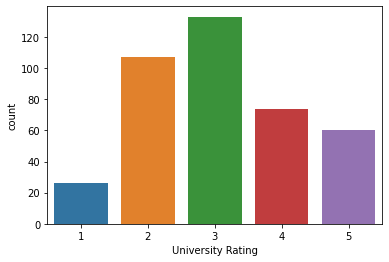

In [17]:
data.Research.value_counts()
sns.countplot(x="University Rating",data=data)

<AxesSubplot:xlabel='University Rating', ylabel='Chance of Admit '>

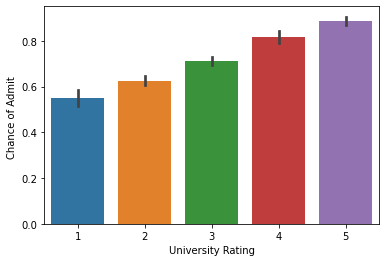

In [18]:
sns.barplot(x="University Rating",y="Chance of Admit ",data=data)

# Data Transformation

In [19]:
x=data.drop(['Serial No.','Chance of Admit '],axis=1)
y=data['Chance of Admit ']

In [20]:
x.shape

(400, 7)

In [21]:
y.shape

(400,)

In [22]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(320, 7)
(80, 7)
(320,)
(80,)


In [23]:
mms=MinMaxScaler()
x_train[x_train.columns]=mms.fit_transform(x_train[x_train.columns].values)
x_test[x_test.columns]=mms.transform(x_test[x_test.columns].values)

# Model Building - Random Forest Regressor

In [55]:
randF=RandomForestRegressor()
randF.fit(x_train,y_train)

RandomForestRegressor()

In [57]:
randF.score(x_test,y_test)

0.7191640539054902

In [26]:
y_pred=model.predict(x_test)
y_pred

array([0.6955, 0.8255, 0.659 , 0.889 , 0.7057, 0.8808, 0.7149, 0.4715,
       0.6497, 0.6832, 0.5319, 0.75  , 0.4753, 0.842 , 0.6333, 0.7586,
       0.652 , 0.6468, 0.7209, 0.6826, 0.8763, 0.7117, 0.6484, 0.5668,
       0.575 , 0.915 , 0.6603, 0.623 , 0.665 , 0.5206, 0.6305, 0.916 ,
       0.7443, 0.9483, 0.7432, 0.6532, 0.9261, 0.7149, 0.5524, 0.9046,
       0.524 , 0.6707, 0.756 , 0.4776, 0.697 , 0.8637, 0.8174, 0.7913,
       0.8475, 0.7333, 0.6806, 0.7101, 0.7888, 0.6571, 0.7243, 0.6667,
       0.5497, 0.8427, 0.7406, 0.4643, 0.7243, 0.9158, 0.7026, 0.6587,
       0.8943, 0.7348, 0.7541, 0.8709, 0.7502, 0.9396, 0.7996, 0.5242,
       0.5233, 0.9429, 0.6773, 0.5597, 0.6476, 0.5119, 0.5124, 0.7639])

In [27]:
y_test

265    0.71
210    0.79
196    0.73
216    0.91
132    0.71
       ... 
317    0.58
54     0.70
161    0.53
377    0.47
360    0.85
Name: Chance of Admit , Length: 80, dtype: float64

# Model Evaluation

In [58]:
print('Model Score : ',randF.score(x_test,y_test))
print('Mean Absolute Error : ',mean_absolute_error(y_test,y_pred))
print('Mean Squared Error : ',mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error : ',np.sqrt(mean_squared_error(y_test,y_pred)))
print('ROC Score : ',roc_auc_score(y_test>0.5,y_pred>0.5))
print('Recall Score : ',recall_score(y_test>0.5,y_pred>0.5))

Model Score :  0.7191640539054902
Mean Absolute Error :  0.05826125000000004
Mean Squared Error :  0.006218472125000007
Root Mean Squared Error :  0.07885728961231173
ROC Score :  0.6291172595520422
Recall Score :  0.9855072463768116


# Model Building - Linear Regressor

In [29]:
x1=data.drop(['Serial No.','Chance of Admit '],axis=1)
y1=data['Chance of Admit ']
x1_train,x1_test,y1_train,y1_test=train_test_split(x1.values,y1.values,test_size=0.2)

sc=StandardScaler()
x1_train-sc.fit_transform(x1_train)
x1_test=sc.fit_transform(x1_test)

In [30]:
model1=LinearRegression()
model1.fit(x1_train,y1_train)
y1_pred=model1.predict(x1_test)
y1_pred

array([-1.45880117, -1.56609796, -1.31434149, -1.19435007, -1.41736752,
       -1.34318141, -1.44159987, -1.17415354, -1.41270588, -1.29024928,
       -1.42350249, -1.27395525, -1.26648225, -1.59865834, -1.27360066,
       -1.33988016, -1.0563721 , -1.53190541, -1.35419674, -1.15036655,
       -1.38763651, -1.45452016, -1.2529685 , -1.19583909, -1.08942794,
       -1.2967477 , -1.3023253 , -1.28589574, -1.5494134 , -1.02616585,
       -1.06328968, -1.42140563, -1.14766203, -1.34707671, -1.62223025,
       -1.3430861 , -1.60004004, -1.0997163 , -1.5030389 , -1.32455385,
       -1.40937284, -1.46320125, -1.35474603, -1.21163598, -1.48652818,
       -1.18694972, -1.31257602, -1.364979  , -1.04870418, -1.22139374,
       -1.20477217, -1.26065964, -1.2873881 , -1.16772023, -1.48117551,
       -1.2385127 , -1.08316204, -1.04257248, -1.37048025, -1.49708866,
       -1.29589595, -1.52364496, -1.39793893, -1.30859781, -1.60550962,
       -1.36615392, -1.01793564, -1.28611817, -1.31040492, -1.25

# Model Evaluation

In [31]:
print('Model Score : ',model1.score(x1_test,y1_test))
print('Mean Absolute Error : ',mean_absolute_error(y1_test,y1_pred))
print('Mean Squared Error : ',mean_squared_error(y1_test,y1_pred))
print('Root Mean Squared Error : ',np.sqrt(mean_squared_error(y1_test,y1_pred)))
print('ROC Score : ',roc_auc_score(y1_test>0.5,y1_pred>0.5))
print('Recall Score : ',recall_score(y1_test>0.5,y1_pred>0.5))

Model Score :  -229.90348413470716
Mean Absolute Error :  2.0404706347151365
Mean Squared Error :  4.167678005421639
Root Mean Squared Error :  2.0414891636796995
ROC Score :  0.5
Recall Score :  0.0


# Model Building - Logistic Regression

In [32]:
x2=data.iloc[:,1:8].values
y2=data.iloc[:,-1:].values
x2_train,x2_test,y2_train,y2_test=train_test_split(x1,y1,test_size=0.2)
y2_train=y2_train>0.5
y2_test=y2_test>0.5

In [33]:
model2=LogisticRegression()
model2.fit(x2_train,y2_train)

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [34]:
y2_pred=model2.predict(x2_test)
y2_pred

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

# Model Evaluation

In [35]:
print('Model Score : ',model2.score(x2_test,y2_test))
print('ROC Score : ',roc_auc_score(y2_test>0.5,y2_pred>0.5))
print('Recall Score : ',recall_score(y2_test>0.5,y2_pred>0.5))

Model Score :  0.9125
ROC Score :  0.5625
Recall Score :  1.0


# Saving The Model

In [59]:
pickle.dump(randF,open('model.pkl','wb'))

In [60]:
xg_reg=xgb.XGBRegressor(objective='reg:logistic',colsample_bytree=0.3,learning_rate=0.5,max_depth=5,n_estimators=100)
x3=data.iloc[:,1:8].values
y3=data.iloc[:,-1:].values

In [61]:
x3_train,x3_test,y3_train,y3_test=train_test_split(x3,y3,test_size=0.2)

In [62]:
xg_reg.fit(x3_test,y3_test)
xg_reg.score(x3_test,y3_test)

0.993065470262444

In [63]:
y3_pred=xg_reg.predict(x3_test)
np.sqrt(mean_squared_error(y3_test,y3_pred))

0.011837333601360536

# IBM WATSON Integration

In [42]:
!pip install ibm_watson_machine_learning

In [44]:
from ibm_watson_machine_learning import APIClient
wml_credentials={
    "url":"https://us-south.ml.cloud.ibm.com",
    "apikey":"pO3a1TZgG2rlPOAcac9ov5Dm4pnE3vqFSSnDr8krcQ0j"
}
client=APIClient(wml_credentials)

In [45]:
def guid_from_space_name(client,space_name):
    space=client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"]==space_name)['metadata']['id'])

In [47]:
space_uid = guid_from_space_name(client,'Models')
print("Space UID : "+ space_uid)

Space UID : 23c7222e-6622-4d86-945b-46ca5ea3d415


In [49]:
client.set.default_space(space_uid)

'SUCCESS'

In [50]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [51]:
software_spec_uid=client.software_specifications.get_uid_by_name("default_py3.7")
software_spec_uid

'e4429883-c883-42b6-87a8-f419d64088cd'

In [69]:
model_details = client.repository.store_model(model=randF,meta_props={
    client.repository.ModelMetaNames.NAME:"MODEL",
    client.repository.ModelMetaNames.TYPE:"scikit-learn_0.23",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_uid
})



Traceback (most recent call last):
  File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/ibm_watson_machine_learning/libs/repo/mlrepositoryclient/model_collection.py", line 254, in _save_scikit_pipeline_model
    model_artifact = self._create_pipeline_model(artifact, query_param)
  File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/ibm_watson_machine_learning/libs/repo/mlrepositoryclient/model_collection.py", line 514, in _create_pipeline_model
    model_artifact = self._create_pipeline_model_v4_cloud(model_artifact, query_param)
  File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/ibm_watson_machine_learning/libs/repo/mlrepositoryclient/model_collection.py", line 1005, in _create_pipeline_model_v4_cloud
    model_output = self.repository_api.ml_assets_model_creation_v4_cloud(model_input, query_param,headers)
  File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/ibm_watson_machine_learning/libs/repo/swagger_client/apis/repository_api.py", line 301,

WMLClientError: Publishing model failed.
Reason: (401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Fri, 18 Nov 2022 19:25:11 GMT', 'Content-Type': 'text/plain; charset=UTF-8', 'Content-Length': '274', 'Connection': 'keep-alive', 'server-timing': 'intid;desc=194aef913689d1e6, intid;desc=194aef913689d1e6', 'WWW-Authenticate': 'Bearer realm="IAM"', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '76c31732beb1e99b-DFW'})
HTTP response body: {
  "trace": "78009241f6d2eda16bc0777891c4759e",
  "errors": [{
    "code": "authorization_rejected",
    "message": "The token is expired since 2022-11-18T19:06:16Z",
    "target": {
      "type": "header",
      "name": "Authorization"
    }
  }],
  "status_code": "401"
}


In [67]:
model_id=client.repository.get_model_uid(model_details)

NameError: name 'model_details' is not defined

In [ ]:
model_id